<a href="https://colab.research.google.com/github/JeanMusenga/TOSEM-2025-Submission/blob/main/TextCNN_with_GloVe_14932PostsMixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://chatgpt.com/share/6b20ab3c-04a2-4b5b-b39b-6531835e3571

In [ ]:
#pip install tensorflow

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import os
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Loading Dataset

In [ ]:
dataset = pd.read_excel('14932_ARPs_and_Programming_Posts.xlsx')

In [ ]:
class_distribution = dataset['Label'].value_counts()
print(class_distribution)

Label
0    7466
1    7466
Name: count, dtype: int64


In [ ]:
# Display class distribution
print(dataset['Label'].value_counts())

Label
0    7466
1    7466
Name: count, dtype: int64


# Posts preprocessing

Cleaning Posts

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup

# Function to remove HTML tags and replace links, images, code snippets, and tables with placeholders
def clean_html(text):
    if not isinstance(text, str):
        return text

    soup = BeautifulSoup(text, "html.parser")

    # Replace all links with '[external-link]'
    for a in soup.find_all('a'):
        a.replace_with('[external-link]')

    # Replace all images with '[figure]'
    for img in soup.find_all('img'):
        img.replace_with('[figure]')

    # Replace all code blocks with '[code-snippet]'
    for code in soup.find_all('code'):  # Fixed this line
        code.replace_with('[code-snippet]')

    # Replace all tables with '[table]'
    for table in soup.find_all('table'):
        table.replace_with('[table]')

    # Get the text without any remaining HTML tags
    clean_text = soup.get_text()

    return clean_text

# Load your DataFrame (assuming df is already defined)
# df = pd.read_csv('your_file.csv')  # Uncomment if loading from a file

# Apply the function to 'Question_body' column
dataset['Question_body_cleaned'] = dataset['Question_body'].apply(clean_html)


# Print sample cleaned data
print(dataset[['Question_body', 'Question_body_cleaned']].head())


                                       Question_body  \
0  <p>When deploying a Windows EC2 instance with ...   
1  I'm pretty new to my company (2 weeks) and we'...   
2  <p>I am trying to figure out how to get <code>...   
3  Say you have an application divided into 3-tie...   
4  <p>I am trying to use the circuit breaker patt...   

                               Question_body_cleaned  
0  When deploying a Windows EC2 instance with Ter...  
1  I'm pretty new to my company (2 weeks) and we'...  
2  I am trying to figure out how to get [code-sni...  
3  Say you have an application divided into 3-tie...  
4  I am trying to use the circuit breaker pattern...  


In [ ]:
# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(str(text))
    tokens = [word.lower() for word in tokens if word.isalpha() and word not in stop_words]
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized)

dataset['Question_body_preprocessed'] = dataset['Question_body_cleaned'].fillna('').apply(preprocess_text)


In [ ]:
# Download and load GloVe embeddings
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

# Tokenization and Glove Embeddings

In [ ]:
# Use tokenizaton from Deep learning models (in our case: TextCNN) and padding
MAX_WORDS = 20000 #Maximum number of words in
MAX_LEN = 100 #This defines the maximum length of each input sequence (i.e., the maximum number of tokens per text).
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(dataset['Question_body_preprocessed'])
X_sequences = tokenizer.texts_to_sequences(dataset['Question_body_preprocessed'])
X_padded = pad_sequences(X_sequences, maxlen=MAX_LEN, padding='post', truncating='post')#Any text longer than 100 tokens will be truncated, and any text shorter than 100 tokens will be padded with zeros (at the end, because of the padding='post' argument).
word_index = tokenizer.word_index


#Glove Embeddings
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe embeddings"):
            values = line.split()
            word = values[0]
            embeddings = np.array(values[1:], dtype='float32')
            embeddings_index[word] = embeddings
    return embeddings_index

glove_path = 'glove.6B.200d.txt'
glove_embeddings_index = load_glove_embeddings(glove_path)

# Create embedding matrix
def create_embedding_matrix(word_index, embeddings_index, embedding_dim=200):
    vocab_size = min(MAX_WORDS, len(word_index) + 1)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = create_embedding_matrix(word_index, glove_embeddings_index, 200)

# Prepare labels
y = dataset['Label'].astype(int).values
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=RANDOM_SEED)


Loading GloVe embeddings: 400000it [00:20, 19238.67it/s]


#Defining TextCNN model

In [ ]:
# Build TextCNN model
def create_text_cnn_model_Glove(vocab_size, embedding_dim, max_length, embedding_matrix):
    inputs = Input(shape=(max_length,))
    embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)(inputs)
    conv1 = Conv1D(128, 3, activation='relu')(embedding)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(128, 4, activation='relu')(embedding)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    conv3 = Conv1D(128, 5, activation='relu')(embedding)
    pool3 = MaxPooling1D(pool_size=2)(conv3)
    concatenated = concatenate([pool1, pool2, pool3], axis=1)
    flatten = Flatten()(concatenated)
    dense1 = Dense(128, activation='relu')(flatten)
    dropout = Dropout(0.5)(dense1)
    outputs = Dense(1, activation='sigmoid')(dropout)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
vocab_size = min(len(word_index) + 1, 20000)  # Limit vocab to 20,000 if needed
text_cnn_model_Glove = create_text_cnn_model_Glove(vocab_size, 200, MAX_LEN, embedding_matrix[:vocab_size])

# Model Summary

In [ ]:
text_cnn_model_Glove.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 200)       │      4,000,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 98, 128)        │         76,928 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 97, 128)        │        102,528 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 96, 128)        │        128,128 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 49, 128)        │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 48, 128)        │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 48, 128)        │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 145, 128)       │              0 │ max_pooling1d[0][0],   │
│                           │                        │                │ max_pooling1d_1[0][0], │
│                           │                        │                │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 18560)          │              0 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │      2,375,808 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │            129 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,683,521 (25.50 MB)

 Trainable params: 2,683,521 (10.24 MB)

 Non-trainable params: 4,000,000 (15.26 MB)

# Train the model

In [ ]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
#history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])
history = text_cnn_model_Glove.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 55s 138ms/step - accuracy: 0.7575 - loss: 0.5597 - val_accuracy: 0.9200 - val_loss: 0.2120
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 53s 142ms/step - accuracy: 0.9444 - loss: 0.1637 - val_accuracy: 0.9170 - val_loss: 0.2257
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 82s 142ms/step - accuracy: 0.9782 - loss: 0.0765 - val_accuracy: 0.9170 - val_loss: 0.2735
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 79s 134ms/step - accuracy: 0.9899 - loss: 0.0301 - val_accuracy: 0.9116 - val_loss: 0.3350
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 81s 133ms/step - accuracy: 0.9920 - loss: 0.0269 - val_accuracy: 0.9029 - val_loss: 0.3998
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 84s 138ms/step - accuracy: 0.9950 - loss: 0.0173 - val_accuracy: 0.9076 - val_loss: 0.4170
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 82s 139ms/step - accuracy: 0.9971 - loss: 0.0102 - val_accuracy: 0.8775 - val_loss: 0.6954
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 53s 142ms/step - accuracy: 0.9915 - loss: 0

# Evaluate model

In [ ]:
# Evaluate model
loss, accuracy = text_cnn_model_Glove.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.9179 - loss: 0.5403
Test Accuracy: 0.9142952561378479


In [ ]:
from sklearn.metrics import accuracy_score

# Predict and evaluate
y_pred = (text_cnn_model_Glove.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)  # Compute accuracy

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

print('------------------------------------------------------------------')

print(f'Precision: {precision}, Recall: {recall}, F1-score: {f1}')
print(f'Accuracy: {accuracy:.4f}')  # Print accuracy

94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1497
           1       0.94      0.89      0.91      1490

    accuracy                           0.91      2987
   macro avg       0.92      0.91      0.91      2987
weighted avg       0.92      0.91      0.91      2987

------------------------------------------------------------------
Precision: [0.89297023 0.93821023], Recall: [0.94188377 0.88657718], F1-score: [0.91677503 0.91166322]
Accuracy: 0.9143


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support

# Predict and evaluate
y_pred = (text_cnn_model_Glove.predict(X_test) > 0.5).astype("int32")

# Compute overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

# Compute precision, recall, F1-score, and support for both classes
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None)

# Compute accuracy per class (TP + TN) / (Total samples)
conf_matrix = confusion_matrix(y_test, y_pred)
class_accuracies = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Print results in the desired format
for i in range(len(precision)):
    print(f'Class {i} - Precision: {precision[i]}, Recall: {recall[i]}, '
          f'F1-score: {f1[i]}, Accuracy: {class_accuracies[i]}')

print(f'Overall Accuracy: {overall_accuracy}')


94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step
Class 0 - Precision: 0.8929702343255225, Recall: 0.9418837675350702, F1-score: 0.9167750325097529, Accuracy: 0.9418837675350702
Class 1 - Precision: 0.9382102272727273, Recall: 0.8865771812080537, F1-score: 0.911663216011042, Accuracy: 0.8865771812080537
Overall Accuracy: 0.9142952795446937


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# Predict and evaluate
y_pred = (text_cnn_model_Glove.predict(X_test) > 0.5).astype("int32")

# Compute overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

# Compute precision, recall, F1-score, and support (overall for binary classification)
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average='binary')

# Compute overall accuracy using confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
overall_accuracy_from_cm = (conf_matrix[0, 0] + conf_matrix[1, 1]) / conf_matrix.sum()

# Print overall results
print(f'Overall Precision: {precision}')
print(f'Overall Recall: {recall}')
print(f'Overall F1-score: {f1}')
print(f'Overall Accuracy: {overall_accuracy}')


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step
Overall Precision: 0.9382102272727273
Overall Recall: 0.8865771812080537
Overall F1-score: 0.911663216011042
Overall Accuracy: 0.9142952795446937


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step


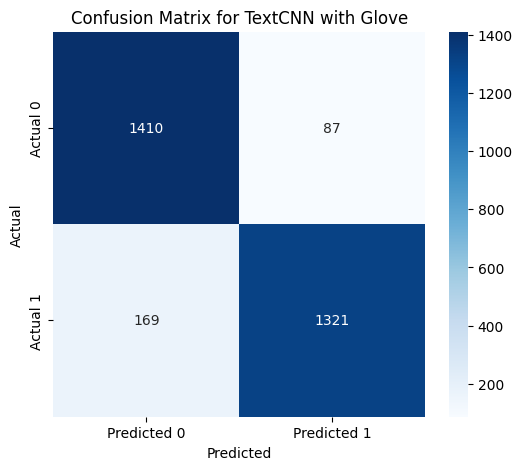

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure y_pred_classes is defined
y_pred_classes = (text_cnn_model_Glove.predict(X_test) > 0.5).astype("int32")

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of TextCNN with Glove')
plt.show()
